In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import scipy as osp

from vb_lib import structure_model_lib, data_utils, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

import time
from copy import deepcopy 

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

In [2]:
data_file = '../simulated_data/simulated_structure_data_nobs1107_nloci2810_npop6.npz'

data = np.load(data_file)

g_obs = np.array(data['g_obs'], dtype = int)

true_pop_allele_freq = np.array(data['true_pop_allele_freq'])
true_ind_admix_propn = np.array(data['true_ind_admix_propn'])
true_z = np.array(data['true_z'])

In [3]:
n_obs = g_obs.shape[0] # number of individuals
n_loci = g_obs.shape[1] # number of loci

# true number of populations
true_n_pop = true_pop_allele_freq.shape[1]

# Plot truth

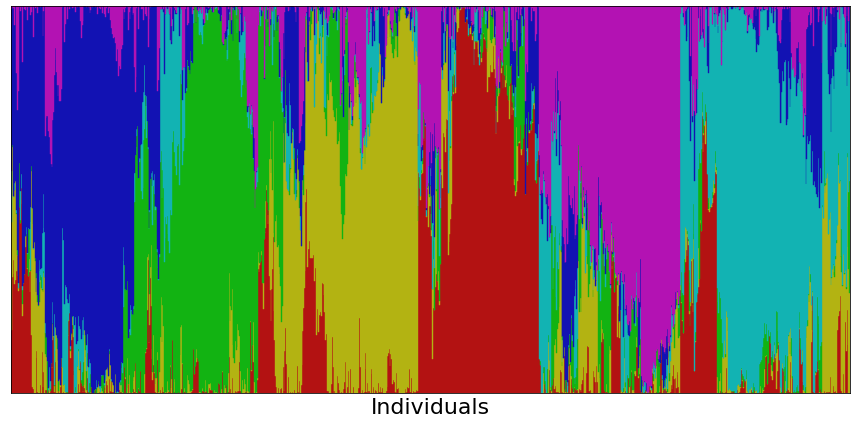

In [4]:
f, axarr = plt.subplots(1, 1, figsize=(12, 6))
plotting_utils.plot_admixture(true_ind_admix_propn, axarr)

axarr.set_xlabel('Individuals', fontsize = 22)

f.tight_layout();

# Load fit

In [5]:
filename = '../fits/simulated_hgdp_fits/simulated_fit_alpha6.0.npz'

In [6]:
bnp_params_dict, vb_params_paragami, meta_data = \
    paragami.load_folded(filename)

k_approx = bnp_params_dict['pop_freq_beta_params'].shape[1]
print(k_approx)

# logitnormal parameters
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)

20


### Check KL

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
prior_params_dict['allele_prior_alpha'] = np.array(meta_data['allele_prior_alpha'])
prior_params_dict['allele_prior_beta'] = np.array(meta_data['allele_prior_beta'])

In [8]:
kl = structure_model_lib.get_kl(g_obs,
                                bnp_params_dict, 
                                prior_params_dict,
                                gh_loc,
                                gh_weights)

In [9]:
kl - meta_data['final_kl']

DeviceArray(1.39698386e-09, dtype=float64)

In [10]:
meta_data['optim_time']

array(2838.04935694)

### Inferred moments

In [11]:
e_ind_admix_bnp, e_pop_freq_bnp = \
    plotting_utils.get_vb_expectations(bnp_params_dict, gh_loc, gh_weights)

In [12]:
from scipy.optimize import linear_sum_assignment

In [13]:
def sort_arrays(estimated_pop_freq, true_pop_freq): 
    
    # this is distance between estimated and true population frequencies
    # rows are truth, columns are estimated 

    dist_matr = onp.array(\
                ((np.expand_dims(estimated_pop_freq, 1) - \
                  np.expand_dims(true_pop_freq, 2))**2).mean(0))
    
    row_ind, col_ind = linear_sum_assignment(dist_matr)
    
    return row_ind, col_ind

In [14]:
# col indx is how we need to permute the estimated population frequencies
# and individual admixtures
row_ind, col_ind = sort_arrays(e_pop_freq_bnp, true_pop_allele_freq)
print(row_ind)
print(col_ind)

[0 1 2 3 4 5]
[1 4 0 2 3 5]


In [15]:
# clean up individual admixtures for plotting
indx = np.arange(k_approx)

# the components without a match
not_col_ind = np.array([indx[i] for i in range(len(indx)) if indx[i] not in col_ind])

# the correct permutation now
bnp_perm_indx = np.concatenate((np.array(col_ind), 
                                not_col_ind))

# permute population frequencies and admixtures
e_ind_admix_bnp_sorted = e_ind_admix_bnp[:, bnp_perm_indx] 
e_pop_freq_bnp_sorted = e_pop_freq_bnp[:, bnp_perm_indx]

# after permuting, sorting indcies should just be 0, 1, 2, ...
print(sort_arrays(e_pop_freq_bnp_sorted, true_pop_allele_freq))

(array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]))


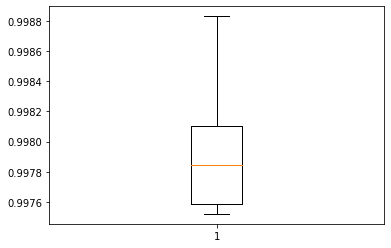

In [16]:
# are the matched components the occupied ones?
plt.boxplot(e_ind_admix_bnp_sorted[:, 0:true_n_pop].sum(1));

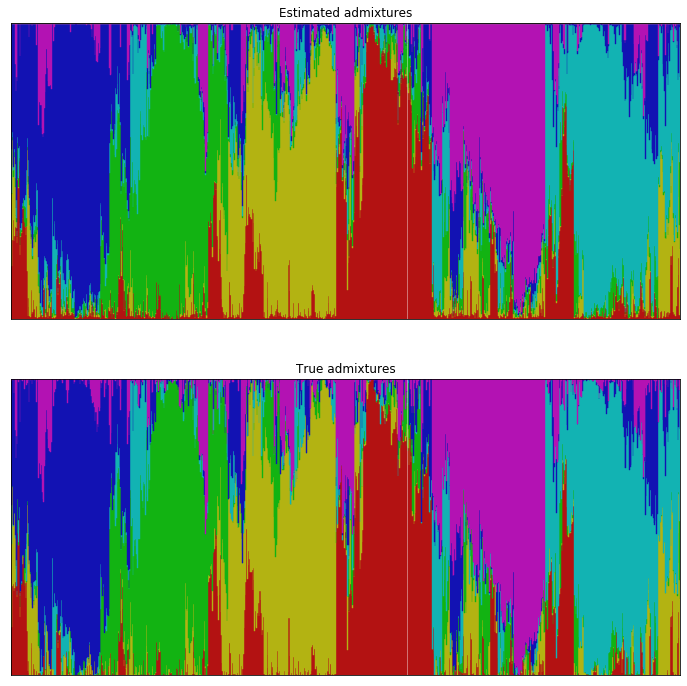

In [17]:
f, axarr = plt.subplots(2, 1, figsize=(12, 12))

###############
# Plot estimated 
###############
axarr[0].set_title('Estimated admixtures')


# plot matched components
# last column is everything else and will be colored grey
_e_ind_admix = np.hstack((e_ind_admix_bnp_sorted[:, 0:true_n_pop], 
                          1 - e_ind_admix_bnp_sorted[:, 0:true_n_pop].sum(1, keepdims = True)))

plotting_utils.plot_top_clusters(_e_ind_admix,
                                 axarr[0], 
                                 n_top_clusters = true_n_pop);


###############
# Plot truth
###############
axarr[1].set_title('True admixtures')
plotting_utils.plot_admixture(true_ind_admix_propn, axarr[1]);


# Fast-structure fit

In [18]:
from vb_lib import fast_structure_lib

In [19]:
filename = '../../../fastStructure/fits/hgdp_sim/simulated_fit.6'
fs_params_dict, _ = fast_structure_lib.load_fs_to_vb_params(filename)

In [20]:
# get expectations
e_ind_admix_fs, e_pop_freq_fs = \
    plotting_utils.get_vb_expectations(fs_params_dict)

# sort
row_ind, fs_perm_indx = sort_arrays(e_pop_freq_fs, true_pop_allele_freq)
e_ind_admix_fs = e_ind_admix_fs[:, fs_perm_indx]
e_pop_freq_fs = e_pop_freq_fs[:, fs_perm_indx]

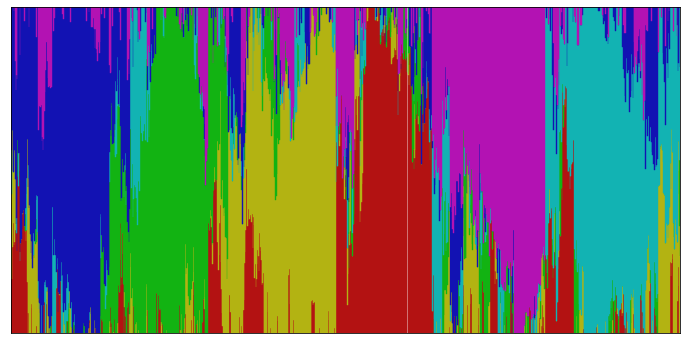

In [21]:
f, axarr = plt.subplots(1, 1, figsize=(12, 6))
plotting_utils.plot_admixture(e_ind_admix_fs, axarr);

# Some metrics

In [22]:
def ind_admix_kl(e_ind_admix, true_ind_admix_propn): 
    
    assert e_ind_admix.shape == true_ind_admix_propn.shape
    
    plogp = true_ind_admix_propn * np.log(true_ind_admix_propn)
    
    plogq = true_ind_admix_propn * np.log(e_ind_admix)
    
    return (plogp - plogq).sum(1).mean()

In [23]:
ind_admix_kl(e_ind_admix_bnp_sorted[:, 0:true_n_pop], 
             true_ind_admix_propn)

DeviceArray(0.04554004, dtype=float64)

In [24]:
ind_admix_kl(e_ind_admix_fs, 
             true_ind_admix_propn)

DeviceArray(0.13722592, dtype=float64)

In [25]:
def error_in_pop_freq(e_pop_freq, true_pop_allele_freq): 
    assert e_pop_freq.shape == true_pop_allele_freq.shape
    
    return np.abs(e_pop_freq - true_pop_allele_freq).mean()

In [26]:
error_in_pop_freq(e_pop_freq_bnp_sorted[:, 0:true_n_pop], 
                  true_pop_allele_freq)

DeviceArray(0.02445973, dtype=float64)

In [27]:
error_in_pop_freq(e_pop_freq_fs,
                  true_pop_allele_freq)

DeviceArray(0.02520548, dtype=float64)

In [28]:
def get_ez(vb_params_dict): 
    
    e_log_sticks, e_log_1m_sticks, \
        e_log_pop_freq, e_log_1m_pop_freq = \
            structure_model_lib.get_moments_from_vb_params_dict(vb_params_dict,
                                                                gh_loc = gh_loc,
                                                                gh_weights = gh_weights)
    
    e_log_cluster_probs = \
        modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
                            e_log_sticks, e_log_1m_sticks)
    
    def f(x): 
        loglik_cond_z_l = structure_model_lib.get_loglik_cond_z_l(x[0], x[1], x[2],
                                                                  e_log_cluster_probs)
        
        return structure_model_lib.get_ez_from_ezfree(loglik_cond_z_l, detach_ez = True)[0]
    
    ez = jax.lax.map(f,
                xs = (g_obs.transpose((1, 0, 2)),
                      e_log_pop_freq, 
                      e_log_1m_pop_freq))
    
    return ez.transpose((1, 0, 2, 3))

In [29]:
ez_bnp = get_ez(bnp_params_dict).block_until_ready()
ez_fs = get_ez(fs_params_dict).block_until_ready()

ez_bnp = ez_bnp[:, :, bnp_perm_indx, :]
ez_fs = ez_fs[:, :, fs_perm_indx, :]

In [30]:
def get_cross_entropy(ez, true_z): 
    return (-true_z * np.log(ez)).sum()

In [31]:
get_cross_entropy(ez_bnp[:, :, 0:true_n_pop, :], true_z)

DeviceArray(5050924.15232043, dtype=float64)

In [32]:
get_cross_entropy(ez_fs, true_z)

DeviceArray(6189835.56042046, dtype=float64)

In [33]:
(ez_fs.argmax(2) == true_z.argmax(2)).mean()

DeviceArray(0.70036873, dtype=float64)

In [34]:
(ez_bnp[:, :, 0:true_n_pop, :].argmax(2) == true_z.argmax(2)).mean()

DeviceArray(0.69873886, dtype=float64)